In [1]:
import os
import sys
import importlib

os.environ["JAX_ENABLE_X64"] = "true"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ['ENABLE_PJRT_COMPATIBILITY'] = 'false'
os.environ["JAX_PLATFORMS"] = "cpu"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
font_axis_label = 16

In [3]:
import src
importlib.import_module(f'src')
for module in dir(src):
    if '__' not in module:
        print(module)
        importlib.import_module(f'src.{module}')
        importlib.reload(sys.modules[f'src.{module}'])

from src.experiments import experiment_toy
from src.theory_utils_spectral import SVR_th_spectral

In [4]:
from copy import deepcopy

def process_data(data):

    data = deepcopy(data)

    def fun_z(prec):

        a = (prec**2+1)*np.pi
        z1 = np.sqrt(np.pi/2)/(4-np.pi) * (a - 2 - np.sqrt((a - 2)**2 - 4*(4 - np.pi)))
        z2 = 1/prec*(1 - prec**2)

        boundary = (2*np.sqrt(4-np.pi)+2-np.pi)/np.pi
        boundary = np.sqrt(boundary)
        mask = prec > boundary

        z = np.zeros_like(prec)
        z[mask] = z1[mask]
        z[~mask] = z2[~mask]

        return z

    try:
        epsilon = data['epsilon_th']
    except:
        epsilon = data['epsilon']

    precision = np.sqrt(data['E_inf'])/(epsilon)
    precision = np.nan_to_num(precision, np.inf)
    precision = np.clip(precision, 1e-5, 1e5)

    epsilon_precision = fun_z(precision)
    data['precision'] = precision
    data['epsilon_precision'] = epsilon_precision
    data['d_prime'] = 1/precision

    return data

In [5]:
P, N, grid_size, num_trials = 800, 25, 50, 25
P, N, grid_size, num_trials = 800, 25, 20, 25

corr_list = np.linspace(0.1, 1, grid_size)
noise_list = np.linspace(0.01, 1, grid_size)
epsilon_list = np.append([-1, -2], np.linspace(0., 2, grid_size))
alpha_list = np.arange(0.1, 3, 0.3)

centroid_seed = 42
fn_list = []

overwrite = False

alldata_file = f'all_data_toy_new_P_{P}_N_{N}'\
    f'_grid_{grid_size}_centroid_seed_{centroid_seed}.npz'

if os.path.exists('./results/'+alldata_file) and not overwrite:
    data = np.load('./results/'+alldata_file, allow_pickle=True)['data'].tolist()
else:
    data = experiment_toy(P=P,
                          N=N,
                          centroid_seed=centroid_seed,
                          grid_size=grid_size,
                          num_trials=num_trials,
                          overwrite=overwrite,
                          SVR_th=SVR_th_spectral,
                          fn_list=fn_list,
                          plot_fig=False,
                          corr_list=corr_list,
                          noise_list=noise_list,
                          epsilon_list=epsilon_list,
                          alpha_list=alpha_list)

corr_list = list(data.keys())
noise_list = list(next(iter(data.values())).keys())

In [6]:
flat_data = dict()
for i, corr in enumerate(corr_list):
    for j, noise in enumerate(noise_list):

        d = data[corr][noise]
        val_shape = np.array(d['C']).shape
        mask = d['Etr'][0] > 1e-5
        mask = d['C'][0] > 1

        for key, val in d.items():

            if flat_data.get(key) is None:
                flat_data[key] = np.zeros((len(corr_list), len(noise_list), *val_shape))

            val = np.array(val).squeeze()

            if len(val.shape) == 0:
                val = np.ones(val_shape)*val

            elif len(val.shape) == 1:

                val = np.array(val)[:, None]
                if val.shape[0] == val_shape[0]:
                    val = val.repeat(val_shape[1], axis=1)
                elif val.shape[0] == val_shape[1]:
                    val = val.repeat(val_shape[0], axis=1).T
                elif val.shape[0] == 1:
                    val = np.ones(val_shape)*val[0]
                elif val.shape[0] == 0:
                    val = np.zeros(val_shape)
                else:
                    continue
                    # raise Exception

            assert val.shape == val_shape, f'{key}, {val.shape}'
            
            if key in ['alpha_eff', 'C', 'epsilon_eff', 'logZ']:
                val[0][mask] = -1e+15
            
            flat_data[key][i, j] = val

        for k in ['noise', 'corr']:
            if flat_data.get(k) is None:
                flat_data[k] = np.zeros((len(corr_list), len(noise_list), *val_shape))

        flat_data['corr'][i, j] = np.ones(val_shape)*corr
        flat_data['noise'][i, j] = np.ones(val_shape)*noise

flat_data = process_data(flat_data)
flat_data = {key: val[3:-5,3:-5,3:,:] for key, val in flat_data.items()}
print(flat_data.keys()), flat_data['Etr'].shape

dict_keys(['pvals_th', 'lamb_th', 'sol_stat', 'sol_kappa_res', 'sol_eps_res', 'f', 'g', 'h', 'alpha_eff', 'alpha', 'p', 'p_eff', 'epsilon', 'epsilon_th', 'lamb_eff', 'lamb', 'E_inf', 'kappa', 'gamma', 'delta', 'epsilon_eff', 'W_tilde', 'C_eps', 'C', 'Q', 'Qhat', 'Chat', 'logZ', 'Etr', 'Etr_raw', 'A', 'eps_opt', 'kappa_opt', 'eps_self', 'kappa_self', 'Rem', 'Dem', 'ED', 'TAD', 'alpha_list', 'alpha_list_th', 'epsilon_list', 'grid_size', 'num_trials', 'fn_list', 'noise', 'corr', 'precision', 'epsilon_precision', 'd_prime'])


/var/folders/wx/0w7lxrcj4b34tm15gpt1zh4h0000gq/T/ipykernel_56429/2457244053.py:28: RuntimeWarning: divide by zero encountered in divide
  precision = np.sqrt(data['E_inf'])/(epsilon)
/var/folders/wx/0w7lxrcj4b34tm15gpt1zh4h0000gq/T/ipykernel_56429/2457244053.py:10: RuntimeWarning: invalid value encountered in sqrt
  z1 = np.sqrt(np.pi/2)/(4-np.pi) * (a - 2 - np.sqrt((a - 2)**2 - 4*(4 - np.pi)))


(None, (12, 12, 19, 100))

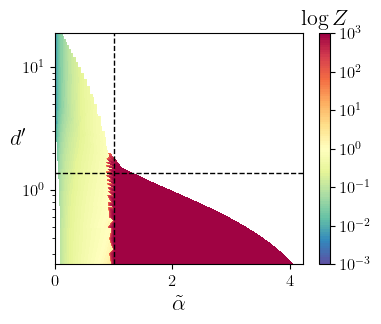

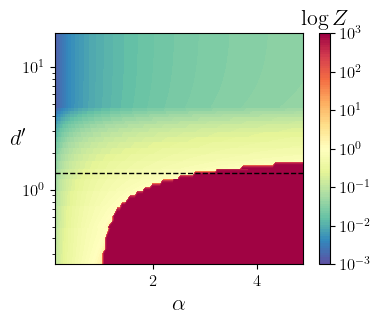

In [7]:
def plot_contours(all_results,
                  val_key='C',
                  ax1_key='alpha',
                  ax2_key='epsilon',
                  ax3_key='noise',
                  ax4_key='corr',
                  ax3_point=5,
                  ax4_point=15,
                  latex=False,
                  savefig=False):

    from matplotlib.ticker import MaxNLocator, LogLocator
    plt.rcParams.update({
        "text.usetex": latex,
        "font.family": "serif",
        'font.size': 12
    })

    all_results = all_results.copy()

    axes = {'corr': 0,
            'noise': 1,
            'epsilon': 2,
            'epsilon_eff': 2,
            'alpha': -1,
            'alpha_eff': -1,
            'precision': 1,
            'd_prime': 1,
            'epsilon_th': 2,
            'epsilon_precision': 2,
            'E_inf': 0}

    labels = {'corr': r"$\beta$",
              'noise': r"$\sigma$",
              'epsilon': r"$\varepsilon$",
              'epsilon_eff': r"$\tilde\varepsilon$",
              'epsilon_th': r"$\tilde\varepsilon$",
              'alpha': r"$\alpha$",
              'alpha_eff': r"$\tilde\alpha$",
              'logZ': r"$\log Z$",
              'C': r"$E_g$",
              'E_inf': r"$E_\infty$",
              'Etr': r"$E_{tr}$",
              'precision': r"$\frac{\sqrt{E_\infty}}{\varepsilon}$",
              'd_prime': r"$d'$",
              'epsilon_precision': 'eps_precision', }

    ax1_idx = axes[ax1_key]
    ax2_idx = axes[ax2_key]
    ax3_idx = axes[ax3_key]
    ax4_idx = axes[ax4_key]

    all_results = {key: np.moveaxis(val, [ax3_idx, ax4_idx, ax1_idx, ax2_idx], [0, 1, 2, 3])
                   for key, val in all_results.items()}

    fig, ax = plt.subplots(nrows=1, figsize=(4, 3))

    x = all_results[ax1_key]
    y = all_results[ax2_key]
    z = all_results[val_key]

    x = np.nan_to_num(x)
    y = np.nan_to_num(y)

    if val_key == 'logZ':
        z = z.clip(1e-3, 1e3)

    elif val_key == 'C' or val_key == 'Etr' or val_key == 'epsilon_th':
        z = z.clip(1e-5, 1e5 if z.max() == 1e15 else 1e3)

    if ax2_key == 'precision' or ax2_key == 'epsilon_precision' or ax2_key == 'd_prime':
        y = y.clip(1e-2, 1e2)
        cutoff = 0.724662
        if ax2_key == 'd_prime':
            cutoff = 1/cutoff
        ax.axhline(cutoff, color='k', ls='--', lw=1)
        ax.set_yscale('log')

    if ax2_key == 'epsilon':
        ax.set_ylim([0, .8])

    if ax1_key == 'alpha_eff' or ax1_key == 'epsilon_eff':
        ax.set_xlim([0, 1.2 if x.min() < 0 else x.max()])
        ax.axvline(1, color='k', ls='--', lw=1)

    if ax2_key == 'alpha_eff' or ax2_key == 'epsilon_eff':
        ax.axhline(1, color='k', ls='--', lw=1)

    if ax1_key == 'precision' and (ax2_key in ['epsilon', 'epsilon_eff', 'alpha']):

        y = y.clip(1e-1, 1e1)
        cutoff = 0.724662
        ax.axvline(cutoff, color='k', ls='--', lw=1)

        ax.set_xlim([1e-1, 2])
        ax.set_ylim([0.5, 2])
        ax.set_xscale('log')
        ax.set_yscale('log')

    if ax1_key == 'epsilon_eff' and (ax2_key in ['alpha_eff']):

        ax.set_xlim([1e-2, 2])
        ax.set_ylim([1e-1, 4])
        ax.set_xscale('log')
        ax.set_yscale('log')

    cmap = plt.get_cmap('Spectral_r')

    nbins = 100
    levels = MaxNLocator(nbins=nbins).tick_values(z.min(), z.max())
    levels = np.logspace(np.log10(z.min()), np.log10(z.max()), nbins)
    locator = LogLocator()
    for i in range(x.shape[0]):
        for j in [ax4_point]:

            if ax1_key == 'alpha_eff' and (ax2_key == 'precision'):

                a_max = all_results['alpha'].max()
                dx = x[i, j][-1]
                dy = y[i, j][-1]

                dy = dy[dx > 1]
                dx = dx[dx > 1]
                plt.plot(dx, dy, 'k-', linewidth=1.5)

                dx = x[:, j].reshape(x.shape[0], -1)
                dy = y[:, j].reshape(x.shape[0], -1)
                idx = np.argmax(all_results['alpha'][:, j].reshape(-1), axis=0)
                if i == 0:
                    plt.plot(dx[:, idx], dy[:, idx], 'k-', linewidth=1.5)

            if ax1_key == 'epsilon_eff' and (ax2_key in ['alpha_eff']):

                a_max = all_results['alpha'].max()

                d = x[i, j]
                ax.plot(d, a_max*(1-d*np.sqrt(2/np.pi)), '--k')
                ax.plot(d, a_max*(1/d*np.sqrt(2/np.pi)*np.exp(-d**2/2)), '--k')

                d = all_results['precision'][i, j][:, -1]
                ax.plot(d, d**(-1) * (1), '--b')
                ax.plot(d, 1/d**2 * np.sqrt(2/np.pi) * (1+(2-np.pi)/np.pi*d**-2), '--r')

            elif ax1_key == 'precision' and (ax2_key in ['epsilon', 'epsilon_eff', 'alpha']):

                d = x[i, j]
                d = np.linspace(0.001, cutoff, 100)
                ax.plot(d, d**(-2) * np.sqrt(2/np.pi) * (1), '--k')

                d = np.linspace(cutoff, 2, 100)
                ax.plot(d, d**(-1)*(1), '--k')

            cf = ax.contourf(x[i, j], y[i, j], z[i, j],
                             levels=levels,
                             cmap=cmap,
                             locator=locator)

    cbar = fig.colorbar(cf)
    cbar.locator = LogLocator(10)
    ticks = cbar.locator.tick_values(z.min(), z.max())[1:-1]
    cbar.set_ticks(ticks)
    cbar.minorticks_off()

    cbar.ax.set_title(labels[val_key], fontsize=font_axis_label)
    ax.set_xlabel(labels[ax1_key], fontsize=font_axis_label)
    ax.set_ylabel(labels[ax2_key], fontsize=font_axis_label, rotation='horizontal')

    if savefig:
        fig.tight_layout()
        fig_name = f'./figures/contour_{val_key}_vs_{ax1_key}_{ax2_key}_at_{ax3_key}_{ax3_point}_{ax4_key}_{ax4_point}.pdf'
        plt.savefig(fig_name, bbox_inches='tight')
    plt.show()


for ax3_point in range(1, 50, 5):
    for ax4_point in range(2, 50, 5):
        lamb = 1e-10
        ax3_point = -1
        ax4_point = -9

        all_results_th = flat_data.copy()
        plot_kwargs = dict(all_results=all_results_th,
                           val_key='C',
                           ax1_key='alpha_eff',
                           ax2_key='d_prime',
                           ax3_key='epsilon',
                           ax4_key='corr',
                           ax3_point=ax3_point,
                           ax4_point=ax4_point,
                           latex=True,
                           savefig=False)

        # plot_contours(**plot_kwargs)

        plot_kwargs['val_key'] = 'logZ'
        plot_contours(**plot_kwargs)

        plot_kwargs['ax1_key'] = 'alpha'
        plot_contours(**plot_kwargs)

        break
    break

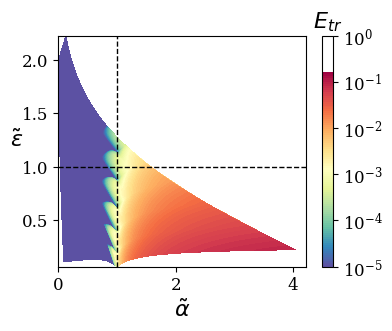

In [8]:
for ax3_point in range(1, 50, 5):
    for ax4_point in range(2, 50, 5):
        lamb = 1e-14
        ax3_point = 15
        ax4_point = 7

        all_results_th = flat_data.copy()
        plot_kwargs = dict(all_results=all_results_th,
                           val_key='Etr',
                           ax1_key='alpha_eff',
                           ax2_key='epsilon_eff',
                           ax3_key='corr',
                           ax4_key='noise',
                           ax3_point=ax3_point,
                           ax4_point=ax4_point)

        plot_contours(**plot_kwargs)

        break
    break